In [1]:
from cellular_automata import * 
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

In [3]:
GENERATIONS = 400
ROWS = COLS = 101
ORIGIN = (COLS // 2, ROWS // 2)
PHI = 1000
CANCER_INIT_POSITIONS = [(ORIGIN[0], ORIGIN[1]), (ORIGIN[0] + 1, ORIGIN[1]), 
                         (ORIGIN[0] - 1, ORIGIN[1]), (ORIGIN[0], ORIGIN[1] - 1), 
                         (ORIGIN[0], ORIGIN[1] + 1)]
K1, K2, K3, K4 = 0.74, 0.2, 0.4, 0.4
RHO = 3.85



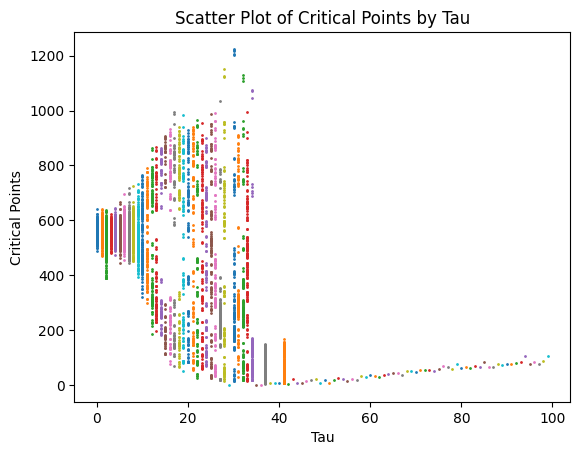

In [7]:
from scipy.signal import find_peaks
GENERATIONS = 1000

critical_points_by_tau = []
taus = []
final_value = []

for tau in range(0, 100):
    history = simulate_tumor_growth(tau, GENERATIONS, ROWS, COLS, PHI, RHO, K1, K2, K3, K4, CANCER_INIT_POSITIONS, ORIGIN)
    Nc_data = np.array([history[i]['Nc'] for i in range(300, 1000)])
    
    peaks, _ = find_peaks(Nc_data, prominence=1)
    peaks_values = Nc_data[peaks]
    troughs, _ = find_peaks(-Nc_data, prominence=1)
    troughs_values = Nc_data[troughs]
    final_value.append(Nc_data[-1])
    combined_values = np.concatenate((peaks_values, troughs_values))
    critical_points_by_tau.append(combined_values)
    taus.append(tau)

for tau in range(0, 100):
    y_values = critical_points_by_tau[tau]
    if y_values.size == 0:
        y_values = [final_value[tau]]
    x_values = [tau] * len(y_values)
    
    plt.scatter(x_values, y_values, s = 1)
    
plt.title('Scatter Plot of Critical Points by Tau')
plt.xlabel('Tau')
plt.ylabel('Critical Points')


plt.show()